# Predicting Road Traffic Collision Severity using Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# this ignores the depreciation warnings etc
import warnings
warnings.filterwarnings("ignore")

#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#pip install pyarrow

In [3]:
vehicle = pd.read_parquet('vehicle_data.parquet') # benchmark
accident = pd.read_parquet('accident_data.parquet') # bench mark
accident_full = pd.read_parquet('accident_data_time_series.parquet') # full data

In [4]:
accident.dropna(subset=['Carriageway_Hazards', 'Road_Surface_Conditions', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Road_Type', 'Special_Conditions_at_Site', 'Latitude', 'Longitude', 'Light_Conditions', 'Pedestrian_Crossing-Human_Control', 'Time', 'Urban_or_Rural_Area', 'Pedestrian_Crossing-Physical_Facilities'], inplace=True)
accident['Weather_Conditions'].replace(np.NaN, 'Unknown', inplace=True)
accident['1st_Road_Class'].replace(np.NaN, 'Unknown', inplace=True)
accident['1st_Road_Number'].replace(np.NaN, 'Unknown', inplace=True)
accident['2nd_Road_Class'].replace(np.NaN, 'Unknown', inplace=True)
accident['2nd_Road_Number'].replace(np.NaN, 'Unknown', inplace=True)
accident['LSOA_of_Accident_Location'].replace(np.NaN, 'Unknown', inplace=True)

accident_full['Speed_limit'].replace(0, np.NaN, inplace=True)
accident_full.dropna(subset=['Speed_limit', 'Carriageway_Hazards', 'Road_Surface_Conditions', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Road_Type', 'Special_Conditions_at_Site', 'Latitude', 'Longitude', 'Light_Conditions', 'Pedestrian_Crossing-Human_Control', 'Time', 'Urban_or_Rural_Area', 'Pedestrian_Crossing-Physical_Facilities'], inplace=True)
accident_full['Weather_Conditions'].replace(np.NaN, 'Unknown', inplace=True)
accident_full['1st_Road_Class'].replace(np.NaN, 'Unknown', inplace=True)
accident_full['1st_Road_Number'].replace(np.NaN, 'Unknown', inplace=True)
accident_full['2nd_Road_Class'].replace(np.NaN, 'Unknown', inplace=True)
accident_full['2nd_Road_Number'].replace(np.NaN, 'Unknown', inplace=True)
accident_full['LSOA_of_Accident_Location'].replace(np.NaN, 'Unknown', inplace=True)

accident_full = accident_full[accident_full['Special_Conditions_at_Site'] != 'Data missing or out of range']
accident_full = accident_full[accident_full['Road_Type'] != 'Unknown']
accident_full = accident_full[accident_full['Road_Surface_Conditions'] != 'Data missing or out of range']
accident_full = accident_full[accident_full['Light_Conditions'] != 'Data missing or out of range']
accident_full = accident_full[accident_full['Carriageway_Hazards'] != 'Data missing or out of range']
accident_full['1st_Road_Class'] = accident_full['1st_Road_Class'].map({"Unclassified": "Unknown"}).fillna(accident_full["1st_Road_Class"])

In [5]:
for column in accident.columns:
    print(column + ' : ' + str(len(accident[column].unique())))
    if(len(accident[column].unique()) < 100):
        print(column + ' : ' + str(accident[column].unique()))
    print('\n')

Accident_Index : 663339


1st_Road_Class : 6
1st_Road_Class : ['B' 'C' 'Unknown' 'A' 'Motorway' 'A(M)']


1st_Road_Number : 6540


2nd_Road_Class : 7
2nd_Road_Class : ['C' 'Unknown' 'Unclassified' 'B' 'A' 'Motorway' 'A(M)']


2nd_Road_Number : 6934


Accident_Severity : 3
Accident_Severity : ['Slight' 'Serious' 'Fatal']


Carriageway_Hazards : 6
Carriageway_Hazards : ['None' 'Other object on road' 'Previous accident'
 'Any animal in carriageway (except ridden horse)' 'Vehicle load on road'
 'Pedestrian in carriageway - not injured']


Date : 2191


Day_of_Week : 7
Day_of_Week : ['Wednesday' 'Thursday' 'Monday' 'Saturday' 'Sunday' 'Tuesday' 'Friday']


Did_Police_Officer_Attend_Scene_of_Accident : 3
Did_Police_Officer_Attend_Scene_of_Accident : [1. 2. 3.]


Junction_Control : 7
Junction_Control : ['Auto traffic signal' 'Data missing or out of range'
 'Give way or uncontrolled' 'Stop sign' 'Authorised person'
 'Auto traffic sigl' 'Not at junction or within 20 metres']


Junction_Detail :

In [6]:
vehicle.dropna(subset=['Vehicle_Location.Restricted_Lane'], inplace=True) 
vehicle['make'].replace(np.NaN, 'Unknown', inplace=True)
vehicle['model'].replace(np.NaN, 'Unknown', inplace=True)
vehicle['Propulsion_Code'].replace(np.NaN, 'Unknown', inplace=True)
vehicle['Driver_IMD_Decile'].replace(np.NaN, 0, inplace=True)
vehicle['Age_of_Vehicle'].replace(np.NaN, -1, inplace=True)
vehicle['Engine_Capacity_.CC.'].replace(np.NaN, -1, inplace=True)

In [7]:
rtc = pd.merge(accident, vehicle, how='left', on='Accident_Index')
#rtc.info()
rtc.dropna(subset=['Age_Band_of_Driver'], inplace=True)
#rtc.info()

In [8]:
accident['Date'] = pd.to_datetime(accident['Date'], format='%d/%m/%Y')
accident['Month'] = accident['Date'].apply(lambda x:x.month)
accident['Time'] = pd.to_datetime(accident['Time'], format='%H:%M')
accident['Hour'] = accident['Time'].apply(lambda x:x.hour)
accident['Junction_Control'] = accident['Junction_Control'].map({"Auto traffic sigl": "Auto traffic signal"}).fillna(accident["Junction_Control"])
accident['Special_Conditions_at_Site'] = accident['Special_Conditions_at_Site'].map({'Auto traffic sigl - out': 'Auto traffic signal - out', 'Auto sigl part defective':'Auto signal part defective'}).fillna(accident["Special_Conditions_at_Site"])
prepped = accident[['1st_Road_Class', '2nd_Road_Class', 'Accident_Severity', 'Carriageway_Hazards', 'Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Hour', 'Urban_or_Rural_Area', 'Weather_Conditions', 'InScotland']]
prepped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037512 entries, 1 to 1048574
Data columns (total 23 columns):
 #   Column                                   Non-Null Count    Dtype  
---  ------                                   --------------    -----  
 0   1st_Road_Class                           1037512 non-null  object 
 1   2nd_Road_Class                           1037512 non-null  object 
 2   Accident_Severity                        1037512 non-null  object 
 3   Carriageway_Hazards                      1037512 non-null  object 
 4   Month                                    1037512 non-null  int64  
 5   Day_of_Week                              1037512 non-null  object 
 6   Junction_Control                         1037512 non-null  object 
 7   Junction_Detail                          1037512 non-null  object 
 8   Latitude                                 1037512 non-null  float64
 9   Light_Conditions                         1037512 non-null  object 
 10  Longitude         

In [9]:
for column in prepped.columns:
    print(column + ' : ' + str(len(prepped[column].unique())))
    if(len(prepped[column].unique()) < 100):
        print(column + ' : ' + str(prepped[column].unique()))
    print('\n')

1st_Road_Class : 6
1st_Road_Class : ['B' 'C' 'Unknown' 'A' 'Motorway' 'A(M)']


2nd_Road_Class : 7
2nd_Road_Class : ['C' 'Unknown' 'Unclassified' 'B' 'A' 'Motorway' 'A(M)']


Accident_Severity : 3
Accident_Severity : ['Slight' 'Serious' 'Fatal']


Carriageway_Hazards : 6
Carriageway_Hazards : ['None' 'Other object on road' 'Previous accident'
 'Any animal in carriageway (except ridden horse)' 'Vehicle load on road'
 'Pedestrian in carriageway - not injured']


Month : 12
Month : [ 1  2  3  4  5  6  7  8  9 10 11 12]


Day_of_Week : 7
Day_of_Week : ['Wednesday' 'Thursday' 'Monday' 'Saturday' 'Sunday' 'Tuesday' 'Friday']


Junction_Control : 6
Junction_Control : ['Auto traffic signal' 'Data missing or out of range'
 'Give way or uncontrolled' 'Stop sign' 'Authorised person'
 'Not at junction or within 20 metres']


Junction_Detail : 10
Junction_Detail : ['Crossroads' 'Not at junction or within 20 metres'
 'T or staggered junction' 'Mini-roundabout' 'Other junction'
 'More than 4 arms (no

In [10]:
accident_full['Date'] = pd.to_datetime(accident_full['Date'], format='%Y-%m-%d')
accident_full['Month'] = accident_full['Date'].apply(lambda x:x.month)
accident_full['Time'] = pd.to_datetime(accident_full['Time'], format='%H:%M')
accident_full['Hour'] = accident_full['Time'].apply(lambda x:x.hour)
accident_full['Junction_Control'] = accident_full['Junction_Control'].map({"Auto traffic sigl": "Auto traffic signal"}).fillna(accident_full["Junction_Control"])
accident_full['Special_Conditions_at_Site'] = accident_full['Special_Conditions_at_Site'].map({'Auto traffic sigl - out': 'Auto traffic signal - out', 'Auto sigl part defective':'Auto signal part defective'}).fillna(accident_full["Special_Conditions_at_Site"])
accident_full['Speed_limit'] = accident_full['Speed_limit'].astype(int)
accident_full['Weather_Conditions'] = accident_full['Weather_Conditions'].map({"Data missing or out of range": "Unknown"}).fillna(accident_full["Weather_Conditions"])

prepped_full = accident_full[['1st_Road_Class', '2nd_Road_Class', 'Accident_Severity', 'Carriageway_Hazards', 'Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Hour', 'Urban_or_Rural_Area', 'Weather_Conditions', 'InScotland', 'Year']]
prepped_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2025923 entries, 0 to 2047255
Data columns (total 24 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   1st_Road_Class                           object 
 1   2nd_Road_Class                           object 
 2   Accident_Severity                        object 
 3   Carriageway_Hazards                      object 
 4   Month                                    int64  
 5   Day_of_Week                              object 
 6   Junction_Control                         object 
 7   Junction_Detail                          object 
 8   Latitude                                 float64
 9   Light_Conditions                         object 
 10  Longitude                                float64
 11  Number_of_Casualties                     int64  
 12  Number_of_Vehicles                       int64  
 13  Pedestrian_Crossing-Human_Control        float64
 14  Pedestrian_Crossin

In [11]:
for column in prepped_full.columns:
    print(column + ' : ' + str(len(prepped_full[column].unique())))
    if(len(prepped_full[column].unique()) < 100):
        print(column + ' : ' + str(prepped_full[column].unique()))
    print('\n')

1st_Road_Class : 6
1st_Road_Class : ['A' 'B' 'C' 'Unknown' 'Motorway' 'A(M)']


2nd_Road_Class : 7
2nd_Road_Class : ['Unknown' 'C' 'Unclassified' 'B' 'A' 'Motorway' 'A(M)']


Accident_Severity : 3
Accident_Severity : ['Serious' 'Slight' 'Fatal']


Carriageway_Hazards : 6
Carriageway_Hazards : ['None' 'Other object on road' 'Pedestrian in carriageway - not injured'
 'Vehicle load on road' 'Previous accident'
 'Any animal in carriageway (except ridden horse)']


Month : 12
Month : [ 1  2  3  4  5  6  7  8  9 10 11 12]


Day_of_Week : 7
Day_of_Week : ['Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Monday' 'Saturday' 'Sunday']


Junction_Control : 6
Junction_Control : ['Data missing or out of range' 'Auto traffic signal'
 'Give way or uncontrolled' 'Stop sign' 'Authorised person'
 'Not at junction or within 20 metres']


Junction_Detail : 10
Junction_Detail : ['Not at junction or within 20 metres' 'Crossroads'
 'T or staggered junction' 'Mini-roundabout' 'Other junction'
 'More than 4 arms (no

In [12]:
encode = pd.get_dummies(prepped, columns = ['1st_Road_Class', '2nd_Road_Class', 'Carriageway_Hazards', 'Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Light_Conditions', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Hour', 'Urban_or_Rural_Area', 'Weather_Conditions', 'InScotland'])
encode_full = pd.get_dummies(prepped_full, columns = ['1st_Road_Class', '2nd_Road_Class', 'Carriageway_Hazards', 'Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Light_Conditions', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Hour', 'Urban_or_Rural_Area', 'Weather_Conditions', 'InScotland'])
encode_full = encode_full[encode_full['Year'] > 2010]

encode_full = encode_full.drop('Year', axis = 1)

encode.info()
encode_full.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037512 entries, 1 to 1048574
Columns: 137 entries, Accident_Severity to InScotland_Yes
dtypes: float64(2), int64(2), object(1), uint8(132)
memory usage: 178.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 976415 entries, 1058570 to 2047255
Data columns (total 137 columns):
 #    Column                                                                 Dtype  
---   ------                                                                 -----  
 0    Accident_Severity                                                      object 
 1    Latitude                                                               float64
 2    Longitude                                                              float64
 3    Number_of_Casualties                                                   int64  
 4    Number_of_Vehicles                                                     int64  
 5    1st_Road_Class_A                                                  

In [13]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['Slight', 'Serious', 'Fatal'], ordered=True)
encode['Accident_Severity'] = encode['Accident_Severity'].astype(cat_type)
#encode['Accident_Severity'].info()
encode['Accident_Severity'] = encode['Accident_Severity'].cat.codes

encode_full['Accident_Severity'] = encode_full['Accident_Severity'].astype(cat_type)
#encode['Accident_Severity'].info()
encode_full['Accident_Severity'] = encode_full['Accident_Severity'].cat.codes

# MODELLING

In [14]:
X = encode.drop('Accident_Severity', axis=1).copy()
y = encode[['Accident_Severity']].copy()

test_size = int(len(X) * .15)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, random_state = 22)

In [15]:
from time import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

classifiers = [
    DecisionTreeClassifier(class_weight='balanced'),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    LGBMClassifier(),
    XGBClassifier(objective='multi:softmax', 
                  n_estimators=10, seed = 22)    
    ]

# Modelling for 2005 - 2010 time period

DecisionTreeClassifier(class_weight='balanced')
	Training time: 29.242s
	Prediction time: 0.153s
	Accuarcy Score: 0.7416884068214823


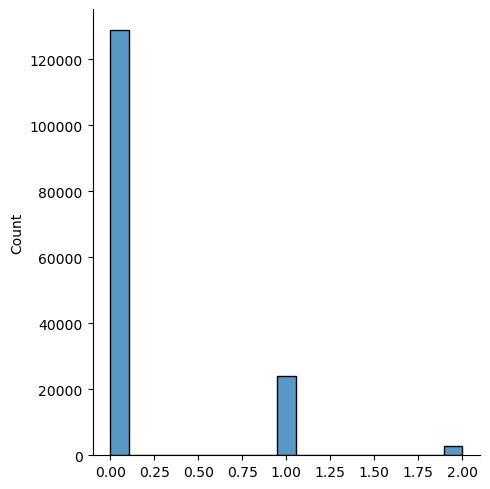

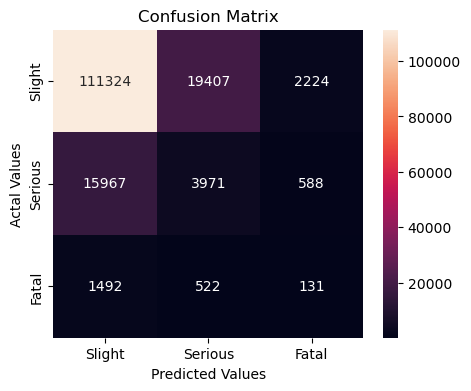

	Positive Predicitive Value - Slight: 0.86
	Positive Predicitive Value - Serious: 0.17
	Positive Predicitive Value - Fatal: 0.04

RandomForestClassifier()
	Training time: 246.049s
	Prediction time: 7.265s
	Accuarcy Score: 0.8516764550910516


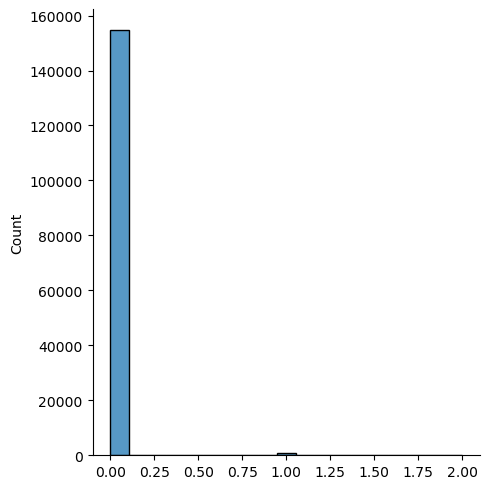

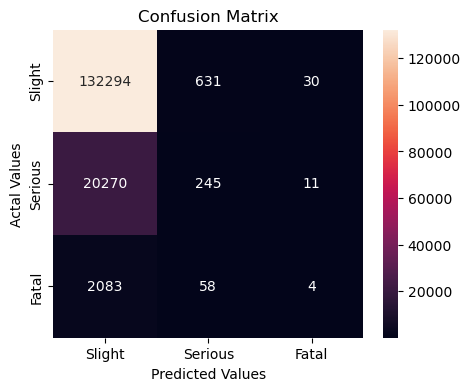

	Positive Predicitive Value - Slight: 0.86
	Positive Predicitive Value - Serious: 0.26
	Positive Predicitive Value - Fatal: 0.09

AdaBoostClassifier()
	Training time: 83.199s
	Prediction time: 3.475s
	Accuarcy Score: 0.8542145913921838


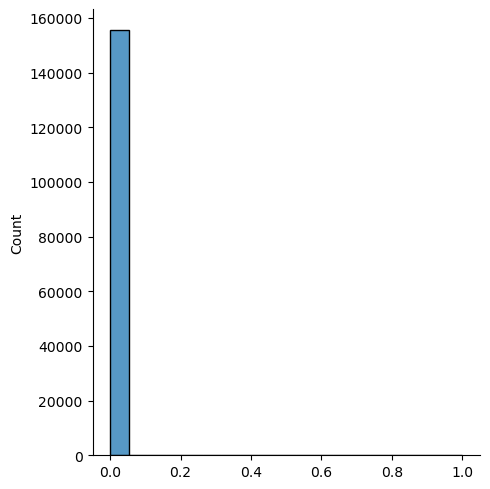

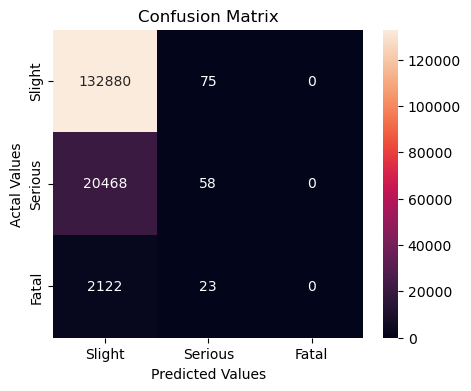

	Positive Predicitive Value - Slight: 0.85
	Positive Predicitive Value - Serious: 0.37
	Positive Predicitive Value - Fatal: nan

LGBMClassifier()
	Training time: 10.995s
	Prediction time: 0.655s
	Accuarcy Score: 0.8544523408684924


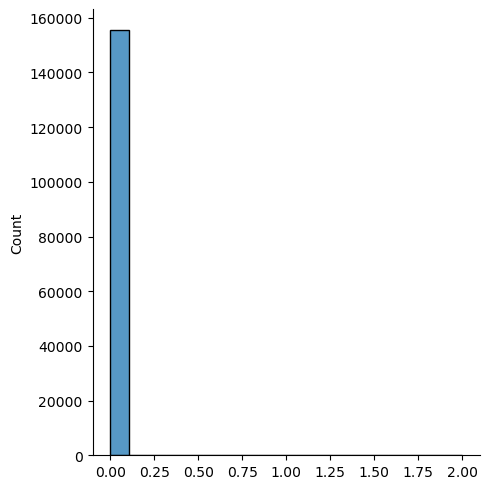

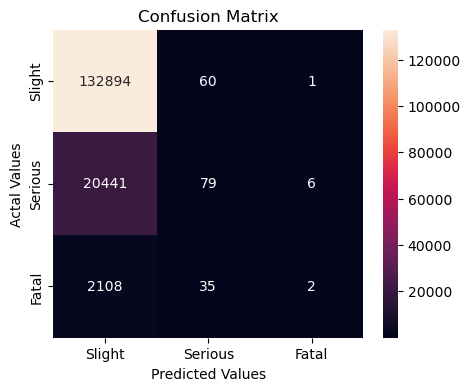

	Positive Predicitive Value - Slight: 0.85
	Positive Predicitive Value - Serious: 0.45
	Positive Predicitive Value - Fatal: 0.22

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, objective='multi:softmax', predictor='auto', ...)
	Training time: 37.286s
	Prediction time: 0.377s
	Accuarcy Score: 0.8544459152069706


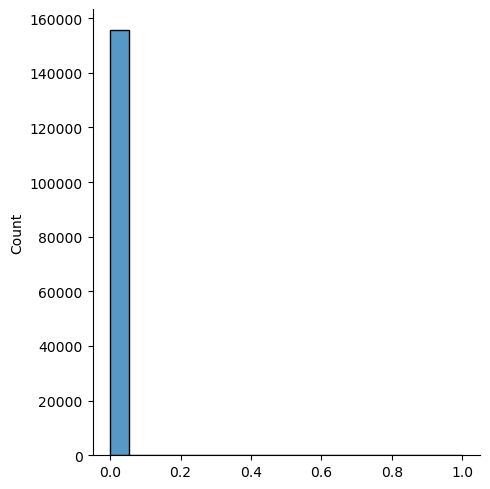

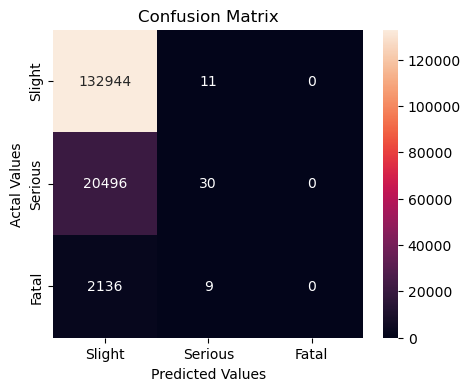

	Positive Predicitive Value - Slight: 0.85
	Positive Predicitive Value - Serious: 0.60
	Positive Predicitive Value - Fatal: nan

Best Model:  LGBMClassifier()
Best Accuracy:  0.8544523408684924


In [16]:
best_Accuracy = 0
best_model = ''
for model in classifiers:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start
    if accuracy_score(y_test, y_pred) > best_Accuracy:
        best_Accuracy = accuracy_score(y_test, y_pred)
        best_model = model
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tAccuarcy Score:", accuracy_score(y_test, y_pred))
    sns.displot(y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(matrix,
                     index = ['Slight', 'Serious', 'Fatal'], 
                     columns = ['Slight', 'Serious', 'Fatal'])
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    # % of predictions that were true positive 
    print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
    print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
    print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
    print()

print('Best Model: ', best_model)
print('Best Accuracy: ', best_Accuracy)

# Modelling for Merged 2005 - 2017 dataset

In [17]:
rtc['Date'] = pd.to_datetime(rtc['Date'], format='%d/%m/%Y')
rtc['Month'] = rtc['Date'].apply(lambda x:x.month)
rtc['Time'] = pd.to_datetime(rtc['Time'], format='%H:%M')
rtc['Hour'] = rtc['Time'].apply(lambda x:x.hour)
rtc['Junction_Control'] = rtc['Junction_Control'].map({"Auto traffic sigl": "Auto traffic signal"}).fillna(rtc["Junction_Control"])
rtc['Special_Conditions_at_Site'] = rtc['Special_Conditions_at_Site'].map({'Auto traffic sigl - out': 'Auto traffic signal - out', 'Auto sigl part defective':'Auto signal part defective'}).fillna(rtc["Special_Conditions_at_Site"])
prepped_rtc = rtc[['1st_Road_Class', '2nd_Road_Class', 'Accident_Severity', 'Carriageway_Hazards', 'Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Hour', 'Urban_or_Rural_Area', 'Weather_Conditions', 'InScotland', 'Age_Band_of_Driver', 'Age_of_Vehicle', 'Driver_Home_Area_Type', 'Driver_IMD_Decile', 'Engine_Capacity_.CC.','Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'Journey_Purpose_of_Driver', 'Junction_Location', 'make', 'Propulsion_Code', 'Sex_of_Driver', 'Skidding_and_Overturning', 'Towing_and_Articulation', 'Vehicle_Leaving_Carriageway', 'Vehicle_Location.Restricted_Lane', 'Vehicle_Manoeuvre', 'Vehicle_Reference', 'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive', 'X1st_Point_of_Impact']]

In [18]:
encode_rtc = pd.get_dummies(prepped_rtc, columns = ['1st_Road_Class', '2nd_Road_Class', 'Carriageway_Hazards', 'Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Light_Conditions', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Hour', 'Urban_or_Rural_Area', 'Weather_Conditions', 'InScotland', 'Age_Band_of_Driver', 'Driver_Home_Area_Type', 'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'Journey_Purpose_of_Driver', 'Junction_Location', 'make', 'Propulsion_Code', 'Sex_of_Driver', 'Skidding_and_Overturning', 'Towing_and_Articulation', 'Vehicle_Leaving_Carriageway', 'Vehicle_Manoeuvre', 'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive', 'X1st_Point_of_Impact'])

In [19]:
encode_rtc['Accident_Severity'] = encode_rtc['Accident_Severity'].astype(cat_type)
encode_rtc['Accident_Severity'] = encode_rtc['Accident_Severity'].cat.codes

In [20]:
rtc_X = encode_rtc.drop('Accident_Severity', axis=1).copy()
rtc_y = encode_rtc[['Accident_Severity']].copy()

test_size_rtc = int(len(rtc_X) * .15)

rtc_X_train, rtc_X_test, rtc_y_train, rtc_y_test = train_test_split(rtc_X, rtc_y, test_size = test_size_rtc, random_state = 22)

DecisionTreeClassifier(class_weight='balanced')
	Training time: 37.860s
	Prediction time: 0.359s
	Accuarcy Score: 0.7775357056402808


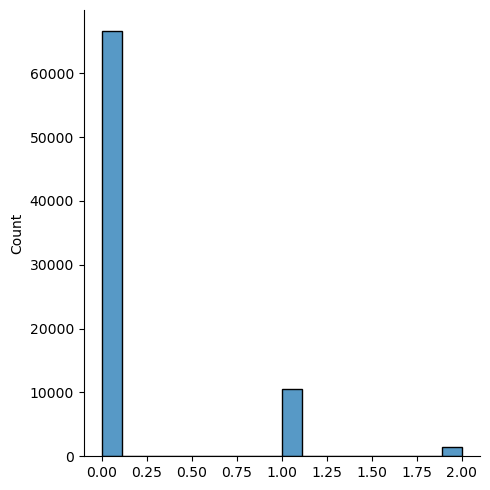

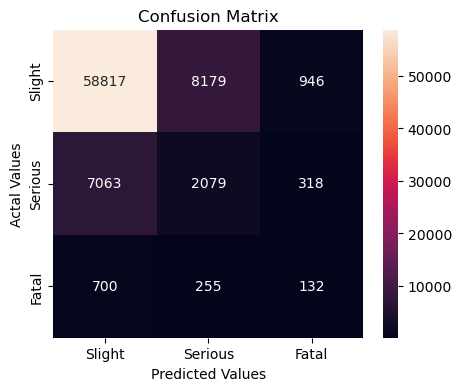

	Positive Predicitive Value - Slight: 0.88
	Positive Predicitive Value - Serious: 0.20
	Positive Predicitive Value - Fatal: 0.09

RandomForestClassifier()
	Training time: 230.034s
	Prediction time: 3.670s
	Accuarcy Score: 0.8667201773496923


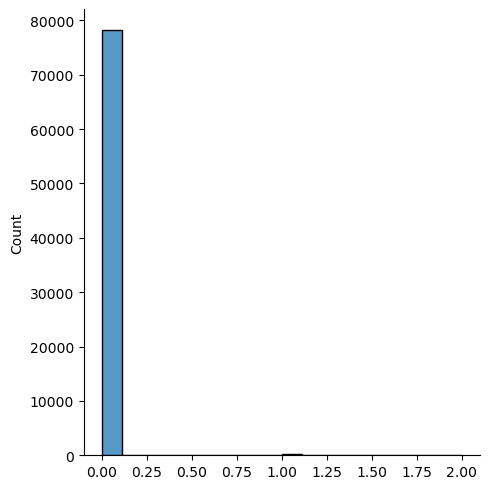

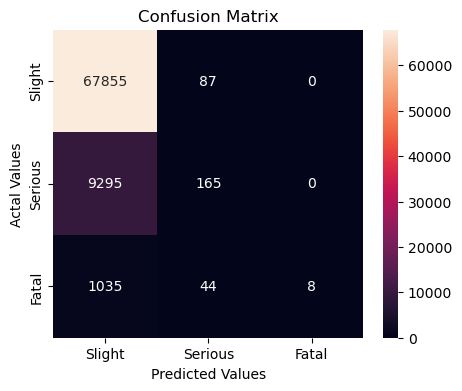

	Positive Predicitive Value - Slight: 0.87
	Positive Predicitive Value - Serious: 0.56
	Positive Predicitive Value - Fatal: 1.00

AdaBoostClassifier()
	Training time: 150.837s
	Prediction time: 7.255s
	Accuarcy Score: 0.8661086266865421


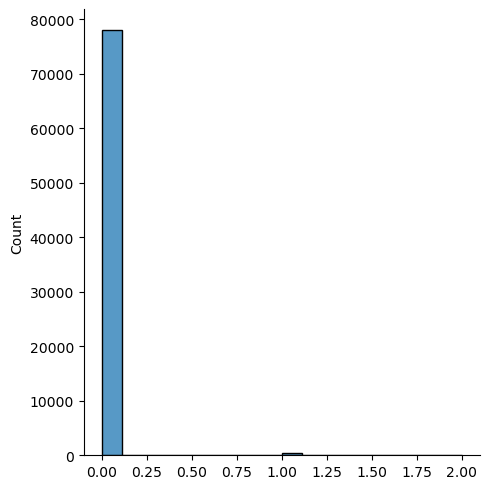

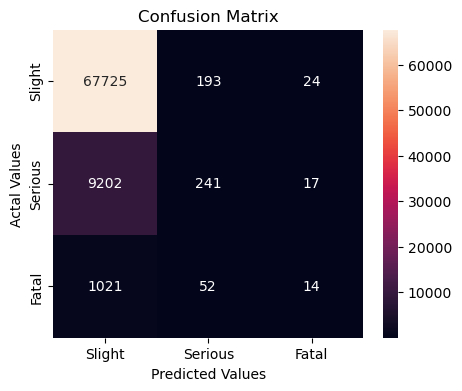

	Positive Predicitive Value - Slight: 0.87
	Positive Predicitive Value - Serious: 0.50
	Positive Predicitive Value - Fatal: 0.25

LGBMClassifier()
	Training time: 9.182s
	Prediction time: 0.667s
	Accuarcy Score: 0.8672680248187644


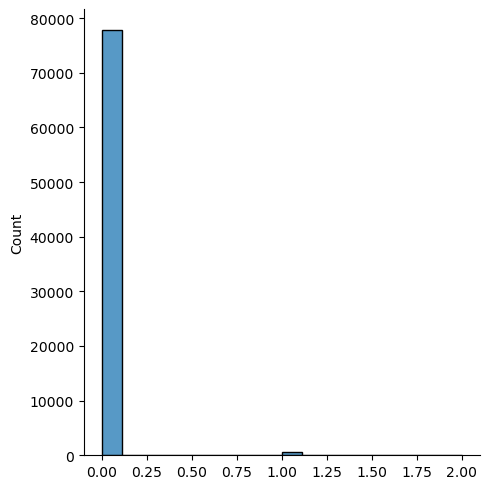

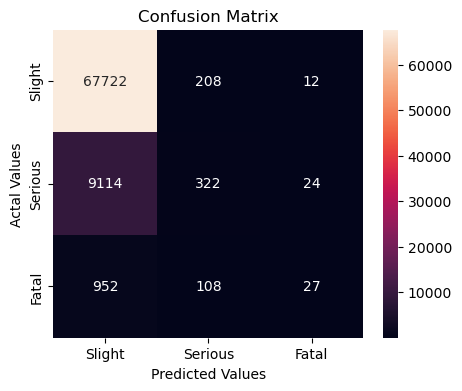

	Positive Predicitive Value - Slight: 0.87
	Positive Predicitive Value - Serious: 0.50
	Positive Predicitive Value - Fatal: 0.43

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, objective='multi:softmax', predictor='auto', ...)
	Training time: 83.750s
	Prediction time: 0.926s
	Accuarcy Score: 0.866796621182586


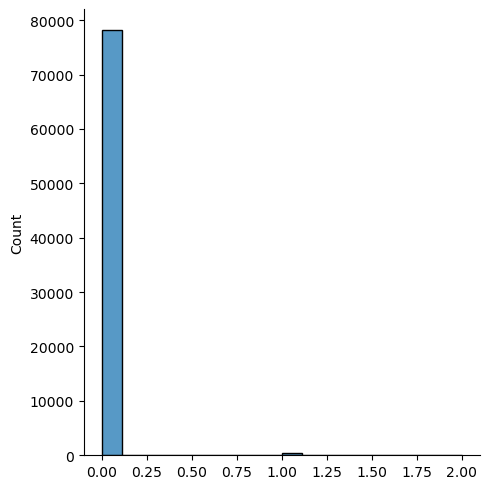

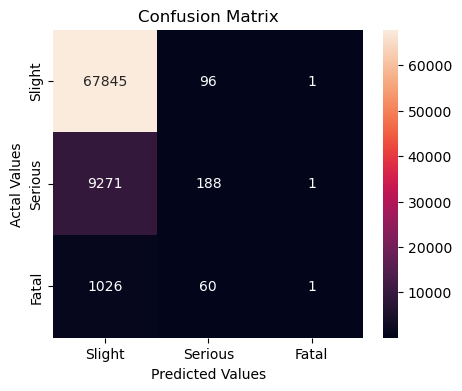

	Positive Predicitive Value - Slight: 0.87
	Positive Predicitive Value - Serious: 0.55
	Positive Predicitive Value - Fatal: 0.33

Best Model:  LGBMClassifier()
Best Accuracy:  0.8544523408684924
Best Model RTC:  LGBMClassifier()
Best Accuracy RTC:  0.8672680248187644


In [21]:
best_Accuracy_rtc = 0
best_model_rtc = ''
for model in classifiers:
    start = time()
    model.fit(rtc_X_train, rtc_y_train)
    train_time = time() - start
    start = time()
    rtc_y_pred = model.predict(rtc_X_test)
    predict_time = time()-start
    if accuracy_score(rtc_y_test, rtc_y_pred) > best_Accuracy_rtc:
        best_Accuracy_rtc = accuracy_score(rtc_y_test, rtc_y_pred)
        best_model_rtc = model
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tAccuarcy Score:", accuracy_score(rtc_y_test, rtc_y_pred))
    sns.displot(rtc_y_pred)
    matrix = confusion_matrix(rtc_y_test, rtc_y_pred)
    cm_df = pd.DataFrame(matrix,
                     index = ['Slight', 'Serious', 'Fatal'], 
                     columns = ['Slight', 'Serious', 'Fatal'])
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
    print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
    print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
    print()

print('Best Model: ', best_model)
print('Best Accuracy: ', best_Accuracy)

print('Best Model RTC: ', best_model_rtc)
print('Best Accuracy RTC: ', best_Accuracy_rtc)

# Class Balancing using Random Under Sampler

In [22]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=22)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(y_resampled.value_counts())

test_size = int(len(X_resampled) * .15)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = test_size, random_state = 22)

Accident_Severity
0                    14431
1                    14431
2                    14431
dtype: int64


DecisionTreeClassifier(class_weight='balanced')
	Training time: 0.757s
	Prediction time: 0.010s
	Accuarcy Score: 0.4159864469428615


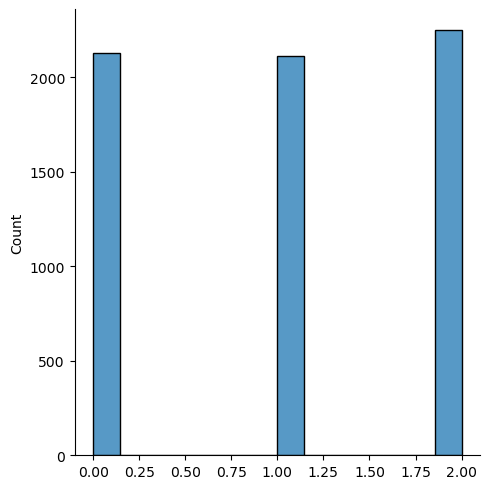

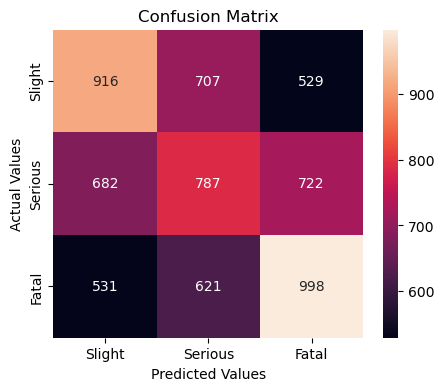

	Positive Predicitive Value - Slight: 0.43
	Positive Predicitive Value - Serious: 0.37
	Positive Predicitive Value - Fatal: 0.44

RandomForestClassifier()
	Training time: 6.786s
	Prediction time: 0.168s
	Accuarcy Score: 0.4825196365316495


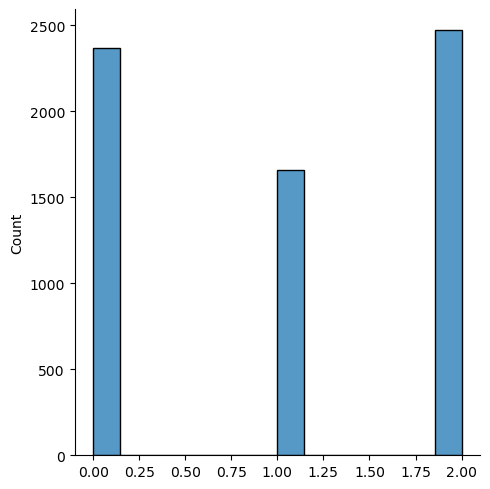

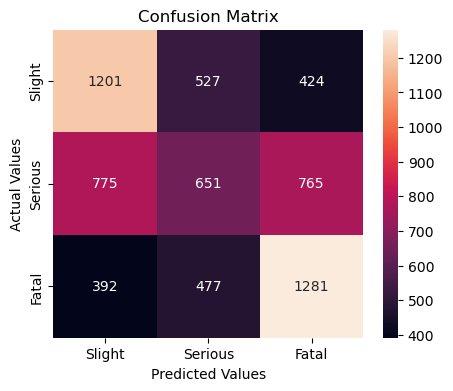

	Positive Predicitive Value - Slight: 0.51
	Positive Predicitive Value - Serious: 0.39
	Positive Predicitive Value - Fatal: 0.52

AdaBoostClassifier()
	Training time: 2.712s
	Prediction time: 0.144s
	Accuarcy Score: 0.5022331741875866


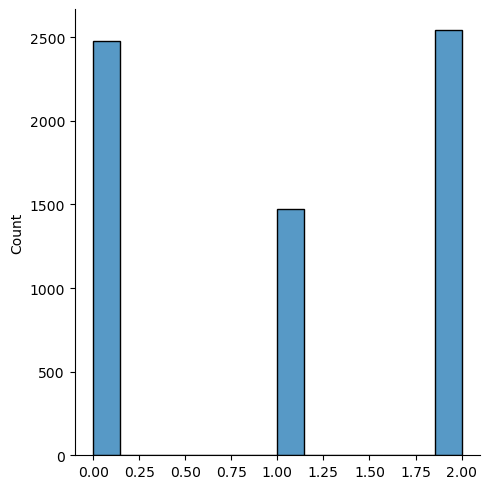

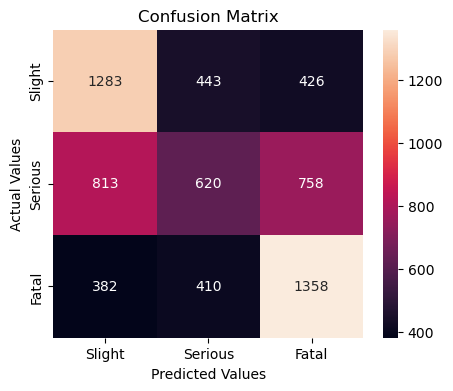

	Positive Predicitive Value - Slight: 0.52
	Positive Predicitive Value - Serious: 0.42
	Positive Predicitive Value - Fatal: 0.53

LGBMClassifier()
	Training time: 0.470s
	Prediction time: 0.030s
	Accuarcy Score: 0.5103958108732481


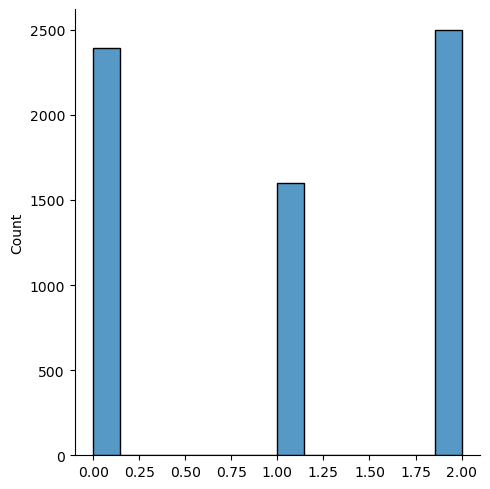

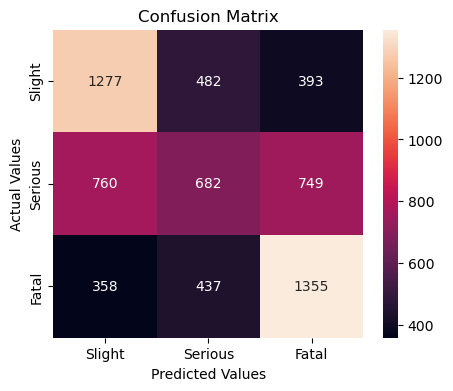

	Positive Predicitive Value - Slight: 0.53
	Positive Predicitive Value - Serious: 0.43
	Positive Predicitive Value - Fatal: 0.54

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, objective='multi:softmax', predictor='auto', ...)
	Training time: 1.593s
	Prediction time: 0.032s
	Accuarcy Score: 0.5057754504851378


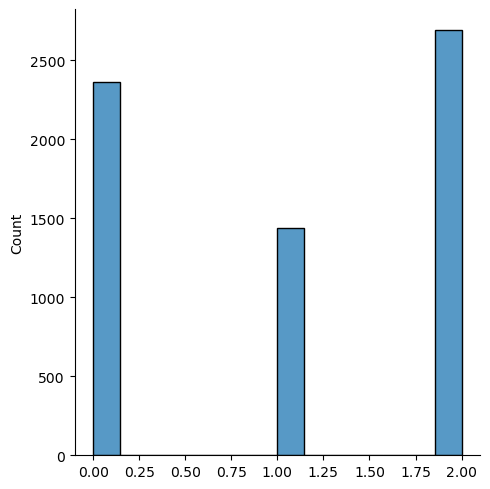

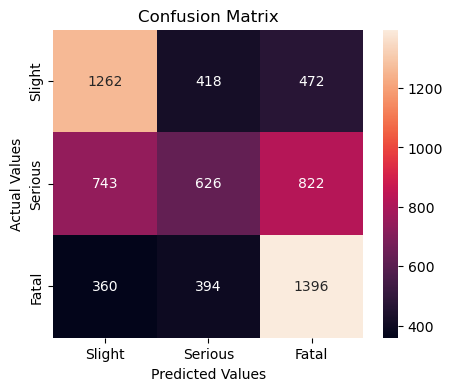

	Positive Predicitive Value - Slight: 0.53
	Positive Predicitive Value - Serious: 0.44
	Positive Predicitive Value - Fatal: 0.52

Best Model:  LGBMClassifier()
Best Accuracy:  0.5103958108732481


In [23]:
best_Accuracy = 0
best_model = ''
for model in classifiers:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start
    if accuracy_score(y_test, y_pred) > best_Accuracy:
        best_Accuracy = accuracy_score(y_test, y_pred)
        best_model = model
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tAccuarcy Score:", accuracy_score(y_test, y_pred))
    sns.displot(y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(matrix,
                     index = ['Slight', 'Serious', 'Fatal'], 
                     columns = ['Slight', 'Serious', 'Fatal'])
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
    print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
    print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
    print()

print('Best Model: ', best_model)
print('Best Accuracy: ', best_Accuracy)

# Class Balancing using SMOTE

## 2005 - 2010 data

Here we are training a model the accident dataset with the SMOTE data. 

In [52]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=22, n_jobs=-1)
X_smote, y_smote = smote.fit_resample(X, y)

test_size = int(len(X_smote) * .15)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = test_size, random_state = 22)

DecisionTreeClassifier(class_weight='balanced')
	Training time: 91.928s
	Prediction time: 0.436s
	Accuarcy Score: 0.8657618141190102


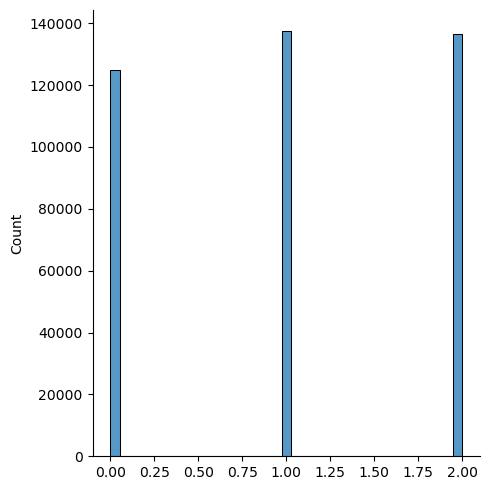

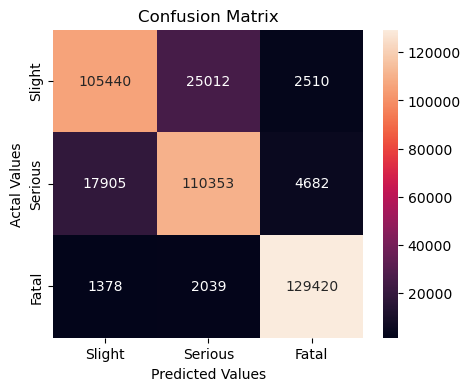

	Positive Predicitive Value - Slight: 0.85
	Positive Predicitive Value - Serious: 0.80
	Positive Predicitive Value - Fatal: 0.95

RandomForestClassifier()
	Training time: 772.001s
	Prediction time: 26.367s
	Accuarcy Score: 0.9359957265278791


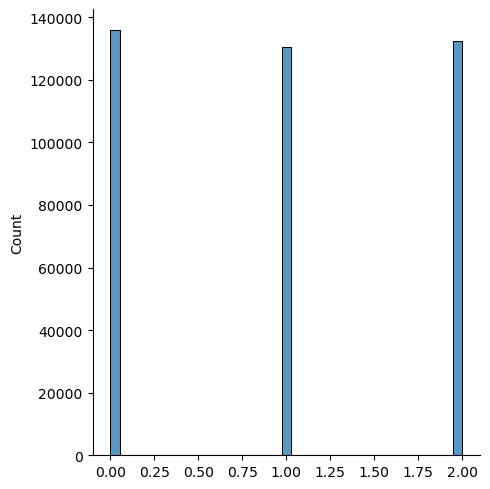

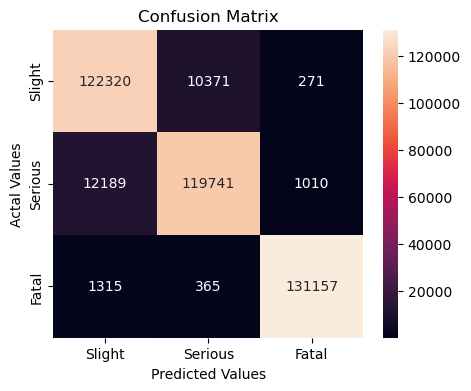

	Positive Predicitive Value - Slight: 0.90
	Positive Predicitive Value - Serious: 0.92
	Positive Predicitive Value - Fatal: 0.99

AdaBoostClassifier()
	Training time: 265.440s
	Prediction time: 8.324s
	Accuarcy Score: 0.6229137355513256


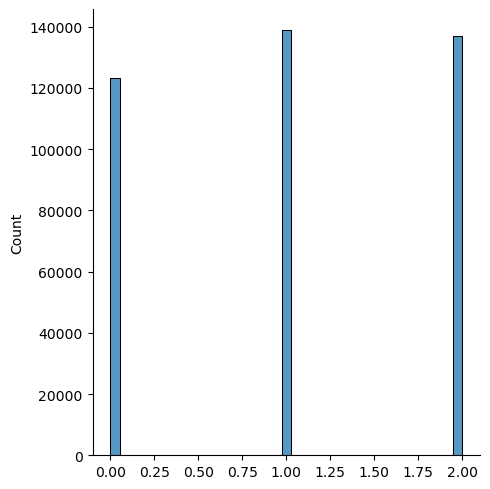

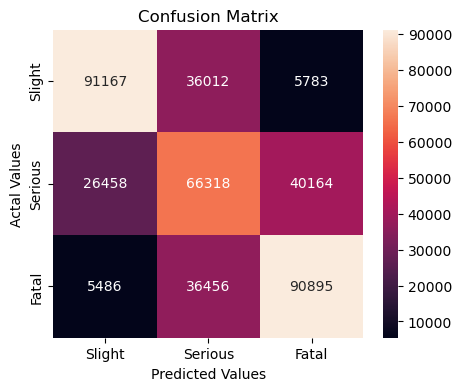

	Positive Predicitive Value - Slight: 0.74
	Positive Predicitive Value - Serious: 0.48
	Positive Predicitive Value - Fatal: 0.66

LGBMClassifier()
	Training time: 39.027s
	Prediction time: 2.083s
	Accuarcy Score: 0.7841645788347766


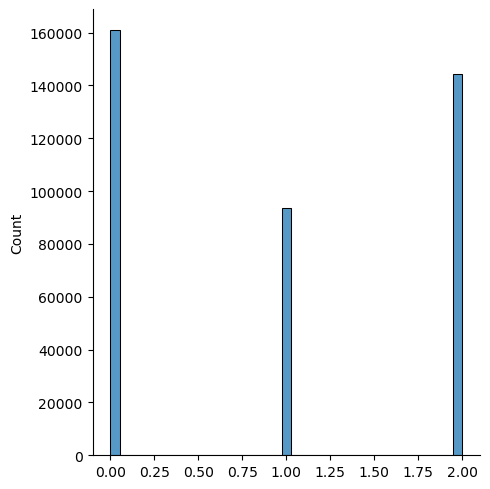

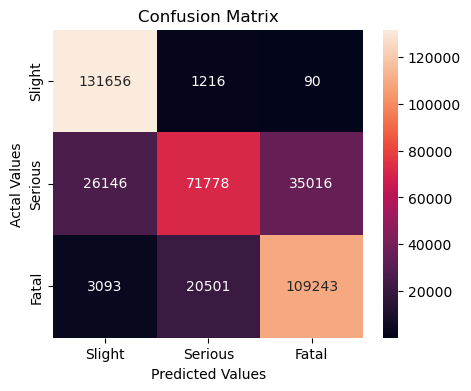

	Positive Predicitive Value - Slight: 0.82
	Positive Predicitive Value - Serious: 0.77
	Positive Predicitive Value - Fatal: 0.76

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, objective='multi:softmax', predictor='auto', ...)
	Training time: 108.337s
	Prediction time: 0.731s
	Accuarcy Score: 0.5857390423309483


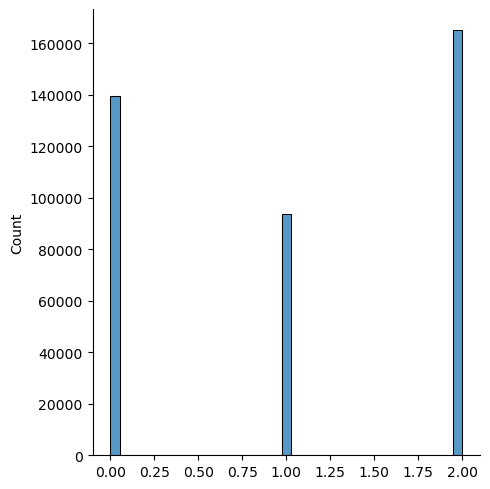

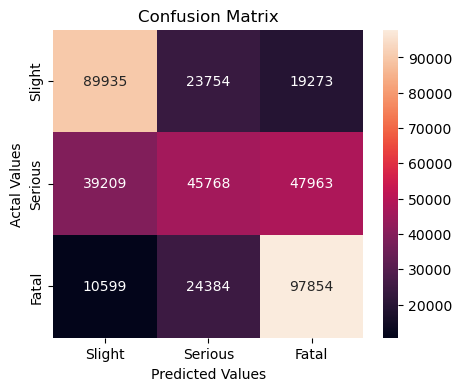

	Positive Predicitive Value - Slight: 0.64
	Positive Predicitive Value - Serious: 0.49
	Positive Predicitive Value - Fatal: 0.59

Best Model:  RandomForestClassifier()
Best Accuracy:  0.9359957265278791


In [53]:
best_Accuracy = 0
best_model = ''
for model in classifiers:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start
    if accuracy_score(y_test, y_pred) > best_Accuracy:
        best_Accuracy = accuracy_score(y_test, y_pred)
        best_model = model
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tAccuarcy Score:", accuracy_score(y_test, y_pred))
    sns.displot(y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(matrix,
                     index = ['Slight', 'Serious', 'Fatal'], 
                     columns = ['Slight', 'Serious', 'Fatal'])
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
    print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
    print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
    print()

print('Best Model: ', best_model)
print('Best Accuracy: ', best_Accuracy)

# Save Best SMOTE Trained Model & Test on 2005 - 2010 Distribution

Here we are testing the SMOTE trained model on the original data.

In [54]:
# save the best model and attempt on validation set
import pickle
filename = 'best_smote_model.pkl'
pickle.dump(best_model, open(filename, 'wb'))

In [55]:
# use validation data 
X = encode.drop('Accident_Severity', axis=1).copy()
y = encode[['Accident_Severity']].copy()

test_size = int(len(X) * .15)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 22)

In [56]:
# load model smote trained model and apply to validation set
loaded_model = pickle.load(open(filename, 'rb'))

y_pred = loaded_model.predict(X_test)

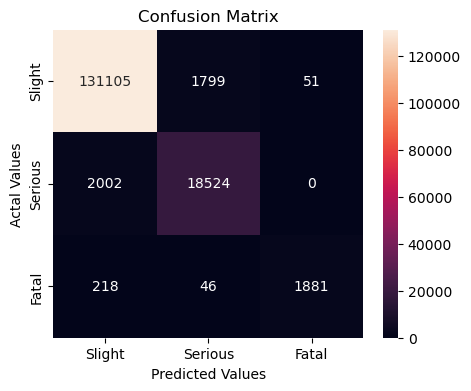

	Positive Predicitive Value - Slight: 0.98
	Positive Predicitive Value - Serious: 0.91
	Positive Predicitive Value - Fatal: 0.97

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    132955
           1       0.91      0.90      0.91     20526
           2       0.97      0.88      0.92      2145

    accuracy                           0.97    155626
   macro avg       0.96      0.92      0.94    155626
weighted avg       0.97      0.97      0.97    155626



In [57]:
from sklearn.metrics import classification_report
matrix = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(matrix,
                     index = ['Slight', 'Serious', 'Fatal'], 
                     columns = ['Slight', 'Serious', 'Fatal'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
print()
print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_pred))

# Test on New Distribution > 2010

In [62]:
# use validation data 
X_f = encode_full.drop('Accident_Severity', axis=1).copy()
y_f = encode_full[['Accident_Severity']].copy()

test_size = int(len(X) * .15)

X_ftrain, X_ftest, y_ftrain, y_ftest = train_test_split(X_f, y_f, test_size = test_size, random_state = 22)

In [63]:
# load model smote trained model and apply to validation set
loaded_model_f = pickle.load(open(filename, 'rb'))

y_fpred = loaded_model_f.predict(X_ftest)

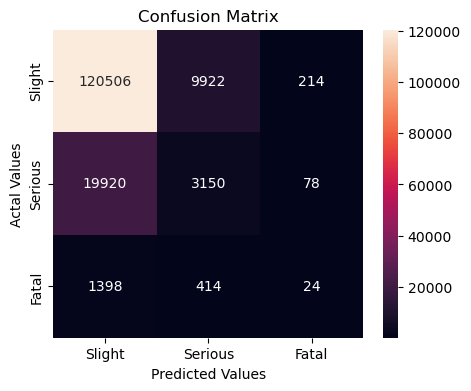

	Positive Predicitive Value - Slight: 0.85
	Positive Predicitive Value - Serious: 0.23
	Positive Predicitive Value - Fatal: 0.08

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.92      0.88    130642
           1       0.23      0.14      0.17     23148
           2       0.08      0.01      0.02      1836

    accuracy                           0.79    155626
   macro avg       0.39      0.36      0.36    155626
weighted avg       0.75      0.79      0.77    155626



In [64]:
from sklearn.metrics import classification_report
matrix = confusion_matrix(y_ftest, y_fpred)
cm_df = pd.DataFrame(matrix,
                     index = ['Slight', 'Serious', 'Fatal'], 
                     columns = ['Slight', 'Serious', 'Fatal'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
print()
print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_ftest, y_fpred))

As we can see,  the well performing SMOTE trained model failed to give any useful results when predicting on a dataset from a different distribution.  The suggested nextsteps are:  model calibration using isotonic regression & adversarial validation. 

## SMOTE Merged 2005 - 2017 data

Here we are training a model the merged accident & vehicle dataset with the SMOTE data. 

In [65]:
rtc_smote = SMOTE(random_state=22, n_jobs=-1)
rtc_X_smote, rtc_y_smote = rtc_smote.fit_resample(rtc_X, rtc_y)

test_size = int(len(rtc_X_smote) * .15)
rtc_X_train, rtc_X_test, rtc_y_train, rtc_y_test = train_test_split(rtc_X_smote, rtc_y_smote, test_size = test_size, random_state = 22)

DecisionTreeClassifier(class_weight='balanced')
	Training time: 103.404s
	Prediction time: 0.662s
	Accuarcy Score: 0.8939431882350053


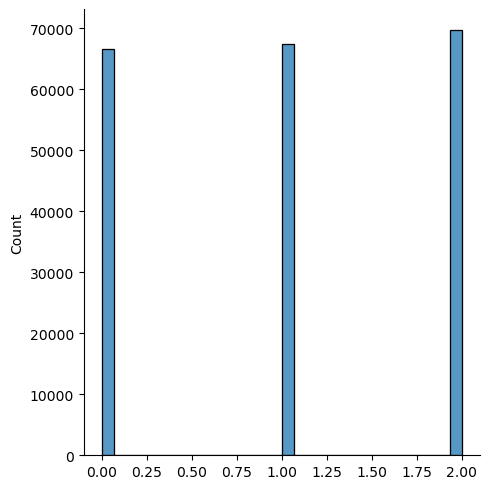

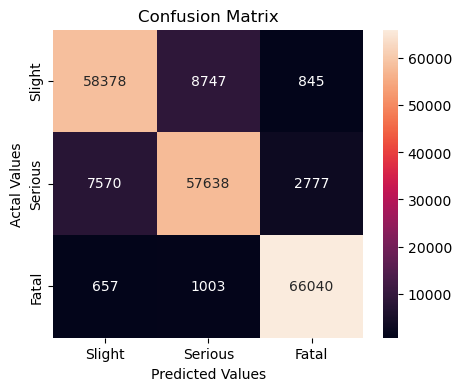

	Positive Predicitive Value - Slight: 0.88
	Positive Predicitive Value - Serious: 0.86
	Positive Predicitive Value - Fatal: 0.95

RandomForestClassifier()
	Training time: 690.020s
	Prediction time: 13.032s
	Accuarcy Score: 0.9481917949473374


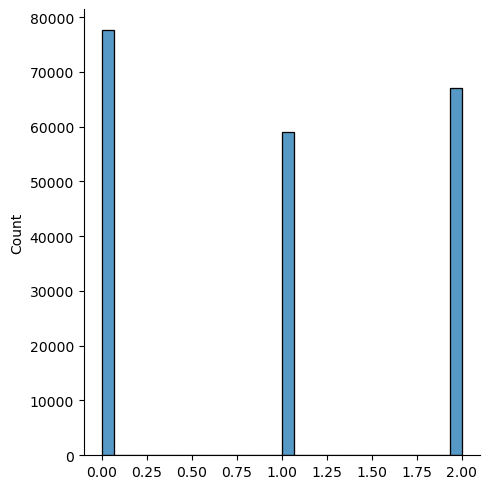

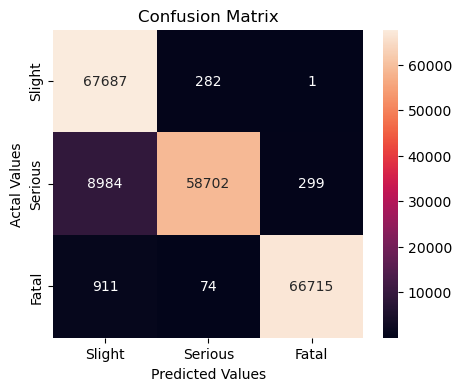

	Positive Predicitive Value - Slight: 0.87
	Positive Predicitive Value - Serious: 0.99
	Positive Predicitive Value - Fatal: 1.00

AdaBoostClassifier()
	Training time: 512.775s
	Prediction time: 19.369s
	Accuarcy Score: 0.7234882521912057


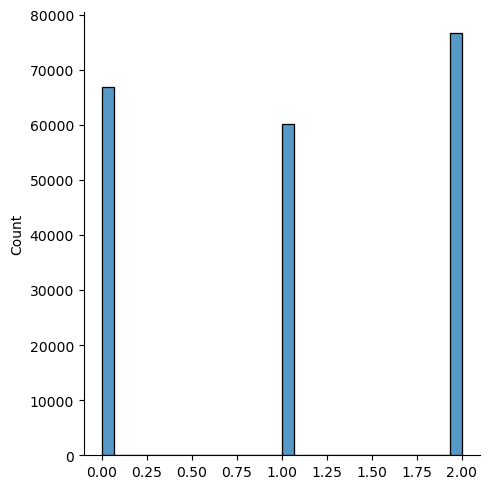

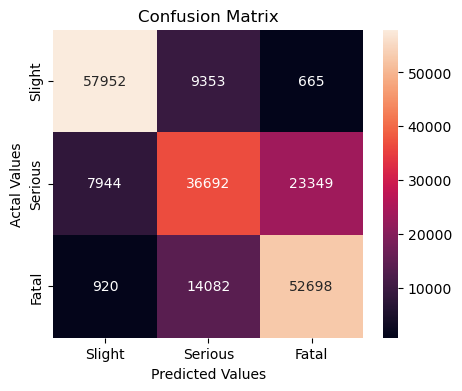

	Positive Predicitive Value - Slight: 0.87
	Positive Predicitive Value - Serious: 0.61
	Positive Predicitive Value - Fatal: 0.69

LGBMClassifier()
	Training time: 43.077s
	Prediction time: 2.131s
	Accuarcy Score: 0.8154182318136064


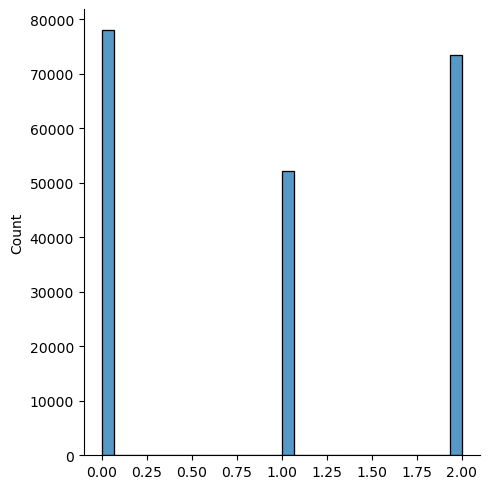

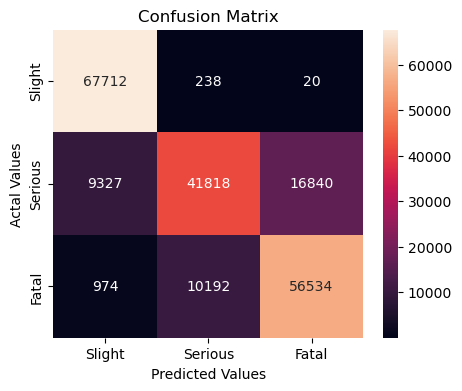

	Positive Predicitive Value - Slight: 0.87
	Positive Predicitive Value - Serious: 0.80
	Positive Predicitive Value - Fatal: 0.77

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, objective='multi:softmax', predictor='auto', ...)
	Training time: 342.029s
	Prediction time: 2.236s
	Accuarcy Score: 0.7639537453045592


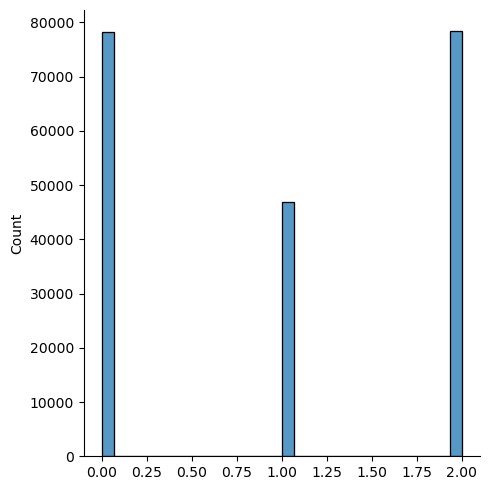

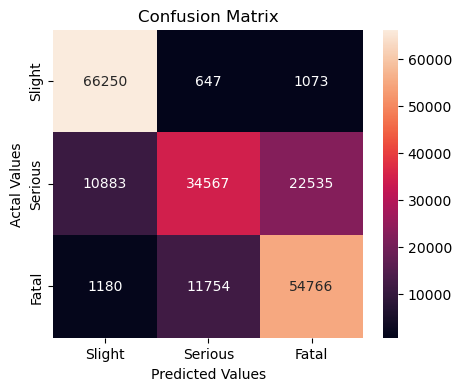

	Positive Predicitive Value - Slight: 0.85
	Positive Predicitive Value - Serious: 0.74
	Positive Predicitive Value - Fatal: 0.70

Best Model:  RandomForestClassifier()
Best Accuracy:  0.9359957265278791
Best Model RTC:  RandomForestClassifier()
Best Accuracy RTC:  0.9481917949473374


In [66]:
best_Accuracy_rtc = 0
best_model_rtc = ''
for model in classifiers:
    start = time()
    model.fit(rtc_X_train, rtc_y_train)
    train_time = time() - start
    start = time()
    rtc_y_pred = model.predict(rtc_X_test)
    predict_time = time()-start
    if accuracy_score(rtc_y_test, rtc_y_pred) > best_Accuracy_rtc:
        best_Accuracy_rtc = accuracy_score(rtc_y_test, rtc_y_pred)
        best_model_rtc = model
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tAccuarcy Score:", accuracy_score(rtc_y_test, rtc_y_pred))
    sns.displot(rtc_y_pred)
    matrix = confusion_matrix(rtc_y_test, rtc_y_pred)
    cm_df = pd.DataFrame(matrix,
                     index = ['Slight', 'Serious', 'Fatal'], 
                     columns = ['Slight', 'Serious', 'Fatal'])
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
    print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
    print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
    print()

print('Best Model: ', best_model)
print('Best Accuracy: ', best_Accuracy)

print('Best Model RTC: ', best_model_rtc)
print('Best Accuracy RTC: ', best_Accuracy_rtc)

# Save Best SMOTE Model & Test on Merged 2005 - 2017 Data

Here we are testing the SMOTE trained model on the original merged data.

In [67]:
# save the best model and attempt on validation set
filename = 'best_smote_model_merged.pkl'
pickle.dump(best_model_rtc, open(filename, 'wb'))

In [68]:
rtc_X = encode_rtc.drop('Accident_Severity', axis=1).copy()
rtc_y = encode_rtc[['Accident_Severity']].copy()

test_size_rtc = int(len(rtc_X) * .15)

rtc_X_train, rtc_X_test, rtc_y_train, rtc_y_test = train_test_split(rtc_X, rtc_y, test_size = test_size_rtc, random_state = 22)

In [69]:
# load model smote trained model and apply to validation set
loaded_model = pickle.load(open(filename, 'rb'))

y_pred = loaded_model.predict(rtc_X_test)

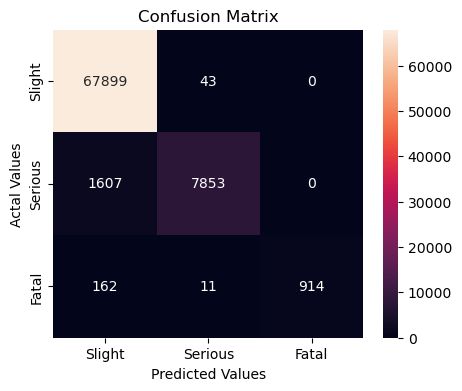

	Positive Predicitive Value - Slight: 0.97
	Positive Predicitive Value - Serious: 0.99
	Positive Predicitive Value - Fatal: 1.00

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     67942
           1       0.99      0.83      0.90      9460
           2       1.00      0.84      0.91      1087

    accuracy                           0.98     78489
   macro avg       0.99      0.89      0.93     78489
weighted avg       0.98      0.98      0.98     78489



In [70]:
matrix = confusion_matrix(rtc_y_test, y_pred)
cm_df = pd.DataFrame(matrix,
                     index = ['Slight', 'Serious', 'Fatal'], 
                     columns = ['Slight', 'Serious', 'Fatal'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
print()
print('Test performance')
print('-------------------------------------------------------')
print(classification_report(rtc_y_test, y_pred))